In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import os
from matplotlib import pyplot as plt
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


In [17]:
def get_file_names(folder):
    #Listing entries present in given folder
    entries = os.listdir(folder)
    for i in entries:
        if 'csv' not in i:
            entries.remove(i)
    return sorted(entries, reverse=True)[0:12]

train_path = "../split_datasets/train/"
test_path = "../split_datasets/test/"
val_path = "../split_datasets/validation/"

train_files = get_file_names(train_path)
test_files = get_file_names(test_path)
val_files = get_file_names(val_path)

frames = []
for i in train_files:
    frames.append(pd.read_csv(train_path+i))
train_df = pd.concat(frames, sort=True)
train_df = train_df.drop(columns="id")
train_df = train_df.drop(columns="last_scraped")
train_df = train_df.fillna(0)

frames = []
for i in test_files:
    frames.append(pd.read_csv(test_path+i))
test_df = pd.concat(frames, sort=True)
test_df = test_df.drop(columns="id")
test_df = test_df.drop(columns="last_scraped")
test_df = test_df.fillna(0)

frames = []
for i in val_files:
    frames.append(pd.read_csv(val_path+i))
val_df = pd.concat(frames, sort=True)
val_df = val_df.drop(columns="id")
val_df = val_df.drop(columns="last_scraped")
val_df = val_df.fillna(0)

minimum = min(train_df['price'].min(), test_df['price'].min(), val_df['price'].min())
maximum = max(train_df['price'].max(), test_df['price'].max(), val_df['price'].max())

train_df['price'] = (train_df['price'] - minimum)/(maximum - minimum)
train_df = train_df.reset_index(drop=True)
test_df['price'] = (test_df['price'] - minimum)/(maximum - minimum)
test_df = test_df.reset_index(drop=True)
val_df['price'] = (val_df['price'] - minimum)/(maximum - minimum)
val_df = val_df.reset_index(drop=True)

print(minimum, maximum)

36 349


In [3]:
class airbnb_dataset (Dataset):
    def __init__(self, df, purpose):
        self.df = df
        self.price = self.df["price"]
        self.df = self.df.drop(columns="price")
        self.purpose = purpose
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        # Returns specific sample as a dict
        if torch.is_tensor(index):
            index = index.tolist()
        sample = torch.tensor(self.df.iloc[index]).float()
        label = torch.tensor([self.price.iloc[index]]).float()
        return {"sample": sample, "label": label}

In [4]:
train_ds = airbnb_dataset(train_df, "train")
test_ds = airbnb_dataset(test_df, "test")
val_ds = airbnb_dataset(val_df, "test")

train_loader = DataLoader(train_ds, batch_size=1000, num_workers=4)
test_loader = DataLoader(test_ds, batch_size=1000, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1000, num_workers=4)

In [18]:
class airbnb_net (nn.Module):
    def __init__(self):
        super(airbnb_net, self).__init__()
        self.layer1 = nn.Linear(264, 400)
        self.layer2 = nn.Linear(400, 200)
        self.layer3 = nn.Linear(200, 100)
        self.layer4 = nn.Linear(100, 1)
    
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        return self.layer4(x)

In [19]:
def train(net, train_loader, val_loader, bounds):
    criterion = nn.MSELoss()
    optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum = 0.9)
    
    print("Starting Training...")
    start_time = time.time()
    epochs, losses = [], []
    
    for epoch in range(75):
        epoch_loss = 0
        epoch_time = time.time()
        batch_loss = 0
        batch_time = time.time()
        for i, data in enumerate(train_loader):
            sample = data["sample"]
            label = data["label"]
            output = net(sample)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            batch_loss += loss
            epoch_loss += loss
            break
            
            if i % 10 == 0:
                batch_loss = batch_loss/10
                print("---[ITER %d] loss: %.6f  time: %.3f" % (i, batch_loss, time.time()-batch_time))
                batch_loss = 0
                batch_time = time.time()
        epoch_loss /= len(train_loader)
        
        epochs.append(epoch)
        losses.append(epoch_loss)
        
        print("[EPOCH %d] loss: %.6f  time: %.3f" % (epoch+1, epoch_loss, time.time()-epoch_time))
        
        if epoch % 5 == 0:
            plt.title("Training Curve")
            plt.plot(losses, label="Train")
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.show()
        
    print("=========================================")
    print("Training Completed...")
    print("[FINAL] loss: %.6f  time: %.3f" % (epoch_loss, time.time()-start_time))
          
        
    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()
    
'''
    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
'''            

'\n    plt.title("Training Curve")\n    plt.plot(epochs, train_acc, label="Train")\n    plt.plot(epochs, valid_acc, label="Validation")\n    plt.xlabel("Epoch")\n    plt.ylabel("Accuracy")\n    plt.legend(loc=\'best\')\n    plt.show()\n'

In [7]:
def get_error(model, train_loader, val_loader, threshold, bounds):
    train_samples = 0
    train_error = 0
    for i, data in enumerate(train_loader):
        sample = data["sample"]
        label = data["label"]
        output = net(sample)
        error = abs(label-output)
        accurate = (error < float(threshold)/float(bounds[1]-bounds[0]))
        train_samples += len(label)
        train_error += error.sum().item()
    val_samples = 0
    val_error = 0
    #for i, data in enumerate(val_loader):
    #    print("hello")
    return train_error    

In [20]:
net = airbnb_net()

Starting Training...
[EPOCH 1] loss: 0.106514  time: 12.317


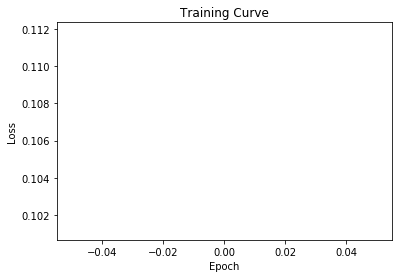

[EPOCH 2] loss: 0.109583  time: 12.719
[EPOCH 3] loss: 0.019704  time: 12.190
[EPOCH 4] loss: 0.044272  time: 12.448
[EPOCH 5] loss: 0.028862  time: 11.947
[EPOCH 6] loss: 0.012056  time: 12.842


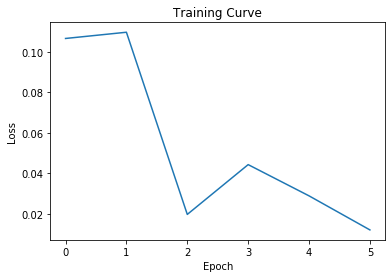

[EPOCH 7] loss: 0.030149  time: 12.598
[EPOCH 8] loss: 0.000480  time: 12.323
[EPOCH 9] loss: 0.021337  time: 14.292
[EPOCH 10] loss: 0.009980  time: 16.979
[EPOCH 11] loss: 0.003368  time: 14.583


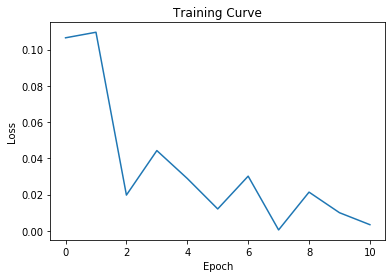

[EPOCH 12] loss: 0.015698  time: 17.594
[EPOCH 13] loss: 0.003244  time: 17.280
[EPOCH 14] loss: 0.003193  time: 12.189
[EPOCH 15] loss: 0.009312  time: 13.151
[EPOCH 16] loss: 0.003098  time: 12.452


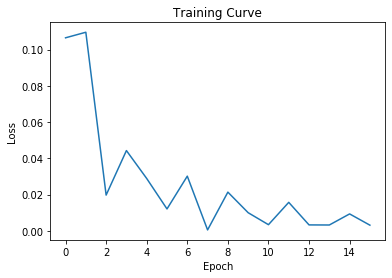

[EPOCH 17] loss: 0.001201  time: 13.075
[EPOCH 18] loss: 0.005857  time: 11.688
[EPOCH 19] loss: 0.003916  time: 13.387
[EPOCH 20] loss: 0.000501  time: 14.976
[EPOCH 21] loss: 0.002416  time: 14.354


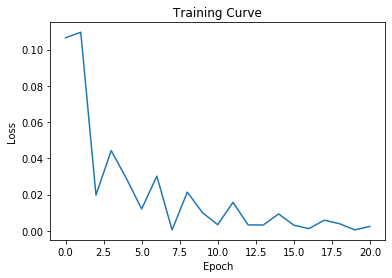

In [ ]:
train(net, train_loader, val_loader, [minimum, maximum])

In [15]:
accum = 0
accum1 = 0
for i in range(100):
    error = net(train_ds[i]["sample"]).item() - train_ds[i]["label"].item()
    accum += error
    accum1 += abs(error)
print("Error:", accum/100)
print("Abs Error:", accum1/100)

Error: -0.0359729637298733
Abs Error: 0.14106640114448965


In [25]:
for i, data in enumerate(train_loader):
    print(len(data["label"]))
    break

1000


In [11]:
train_ds[4]["label"].item()


135.0